# CarND-Capstone traffic light detection
Traffic light detection solution of Ernesto Cañibano

# Use Object detection API with TensorFlow 1.3.0

According to [releases](https://github.com/tensorflow/tensorflow/releases?after=v1.5.0-rc1), Tensorflow 1.3.0. came out on August 16, 2017. So you will need to use the corresponding version of the [Object Detection API](https://github.com/tensorflow/models/tree/289a2f99a7df528f6193a5ab3ee284ff3112b731). At that time, the [Protocol Buffers v3.4.0](https://github.com/protocolbuffers/protobuf/releases?after=v3.5.2) were the latest, so you need to use them as well.

You might get ValueError: ''axis = 0 not in (0, 0)'' (I don't have it confirmed, but I suspect this error shows up when you created your TFRecords using the newer Object Detection API.) Just in case the link doesn't work, the solution is to modify your pipeline *.config, like so:
```
loss {
  classification_loss {
    weighted_sigmoid {
    anchorwise_output: true  #add this
    }
  }
  localization_loss {
    weighted_smooth_l1 {
    anchorwise_output: true  #add this
    }
  }
  hard_example_miner {
    num_hard_examples: 3000
    iou_threshold: 0.99
    loss_type: CLASSIFICATION
    max_negatives_per_positive: 3
    min_negatives_per_image: 0
  }
  classification_weight: 1.0
  localization_weight: 1.0
}
```

# Download pretrained models

In [ ]:
!wget -P tl_classifier/models  http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2018_01_28.tar.gz
!tar -xzvf tl_classifier/models/ssd_inception_v2_coco_2018_01_28.tar.gz -o -C tl_classifier/models
!wget -P tl_classifier/models https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/samples/configs/ssd_inception_v2_coco.config

In [ ]:
!wget -P tl_classifier/models  http://download.tensorflow.org/models/object_detection/faster_rcnn_inception_v2_coco_2018_01_28.tar.gz
!tar -xzvf tl_classifier/models/faster_rcnn_inception_v2_coco_2018_01_28.tar.gz -o -C tl_classifier/models
!wget -P tl_classifier/models https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/samples/configs/faster_rcnn_inception_v2_coco.config

In [ ]:
!wget -P tl_classifier/models  http://download.tensorflow.org/models/object_detection/http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2018_01_28.tar.gz
!tar -xzvf tl_classifier/models/ssd_mobilenet_v1_coco_2018_01_28.tar.gz -o -C tl_classifier/models
!wget -P tl_classifier/models https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/samples/configs/ssd_mobilenet_v1_coco.config

# Generate dataset

In [ ]:
import os
import shutil
i = 0  
for filename in os.listdir("tl_classifier/data_real/recording"): 
    if i % 60 == 0:
        src ='tl_classifier/data_real/recording/'+ filename 
        dst = 'tl_classifier/data_real/images/test/' + filename  
        shutil.move(src, dst)
    i = i + 1

In [ ]:
import os
i = 0  
for filename in os.listdir("tl_classifier/data_real/recording"): 
    dst ="real_{:04d}.jpg".format(i)
    i = i + 1    
    src ='tl_classifier/data_real/recording/'+ filename 
    dst = 'tl_classifier/data_real/recording/' + dst  
    os.rename(src, dst) 

## Simulator dataset
Firs step is to label the dataset images usign [labelImg](https://github.com/tzutalin/labelImg) .

In [ ]:
import sys
sys.path.append("..")

In [ ]:
%run tl_classifier/xml_to_csv.py tl_classifier/data_sim

In [ ]:
#execute in terminal in directory "models/object_detection"
#dont forget: export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim
%run tl_classifier/generate_tfrecord.py --csv_input=tl_classifier/data_sim/data/train_labels.csv --output_path=tl_classifier/data_sim/data/train.record --image_dir=tl_classifier/data_sim/images/train
%run tl_classifier/generate_tfrecord.py --csv_input=tl_classifier/data_sim/data/test_labels.csv --output_path=tl_classifier/data_sim/data/test.record --image_dir=tl_classifier/data_sim/images/test


## Real site dataset

In [1]:
%run tl_classifier/xml_to_csv.py tl_classifier/data_real

Successfully converted xml to csv.
Successfully converted xml to csv.


In [ ]:
#execute in terminal in directory "models/object_detection"
#dont forget: export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim
%run tl_classifier/generate_tfrecord.py --csv_input=tl_classifier/data_real/data/train_labels.csv --output_path=tl_classifier/data_real/data/train.record --image_dir=tl_classifier/data_real/images/train
%run tl_classifier/generate_tfrecord.py --csv_input=tl_classifier/data_real/data/test_labels.csv --output_path=tl_classifier/data_real/data/test.record --image_dir=tl_classifier/data_real/images/test


# Train models

In [ ]:
#execute in terminal in directory "models/object_detection/"
#dont forget execute from "models/" export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim

## Simulator model

In [ ]:
%run train.py --logtostderr --train_dir=tl_classifier/data_sim/ouput_model --pipeline_config_path=tl_classifier/models/ssd_inception_v2_coco_sim.config


In [ ]:
%run export_inference_graph.py \
    --input_type image_tensor \
    --pipeline_config_path tl_classifier/models/ssd_inception_v2_coco_sim.config \
    --trained_checkpoint_prefix tl_classifier/data_sim/ouput_model/model.ckpt-5000 \
    --output_directory tl_classifier/data_sim/ouput_model

## Real site model

In [ ]:
%run train.py --logtostderr --train_dir=tl_classifier/data_real/ouput_model --pipeline_config_path=tl_classifier/models/ssd_inception_v2_coco_real.config


In [ ]:
%run export_inference_graph.py \
    --input_type image_tensor \
    --pipeline_config_path tl_classifier/models/faster_rcnn_inception_v2_coco_real.config \
    --trained_checkpoint_prefix tl_classifier/data_real/ouput_model/model.ckpt-5000 \
    --output_directory tl_classifier/data_real/ouput_model

# Test the models

### Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

### Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

### Object detection imports
Here are the imports from the object detection module.

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

### Model preparation 

#### Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [4]:
# What model to load.
MODEL_NAME = 'tl_classifier/data_real/frozen_models'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/ssd_inception_v2_real_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('tl_classifier/data_real', 'object-detection.pbtx')

NUM_CLASSES = 4

## Load a (frozen) Tensorflow model into memory.

In [5]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [6]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


## Helper code

In [7]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [8]:
from glob import glob
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'tl_classifier/data_real/images/test'
TEST_IMAGE_PATHS = glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

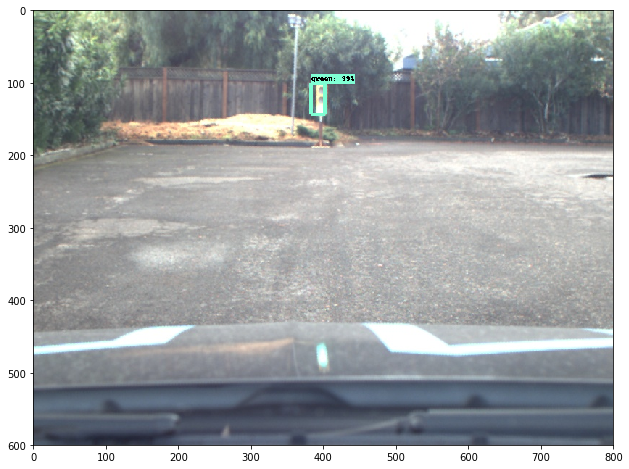

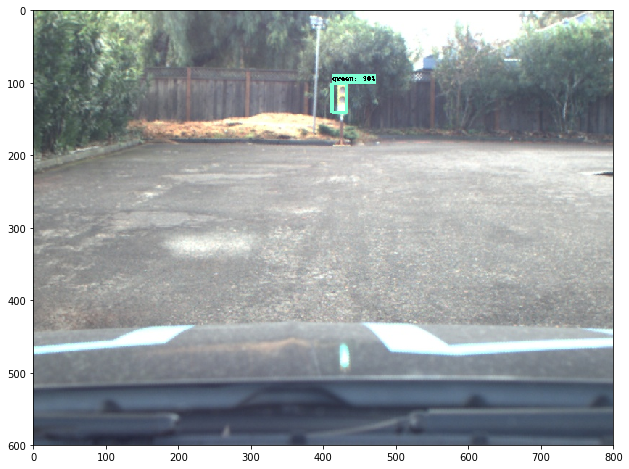

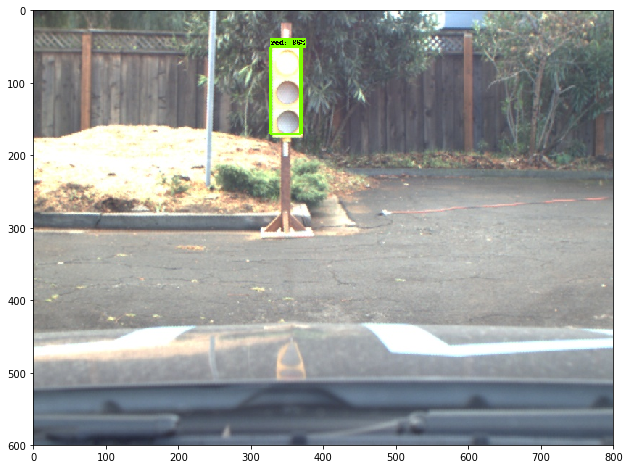

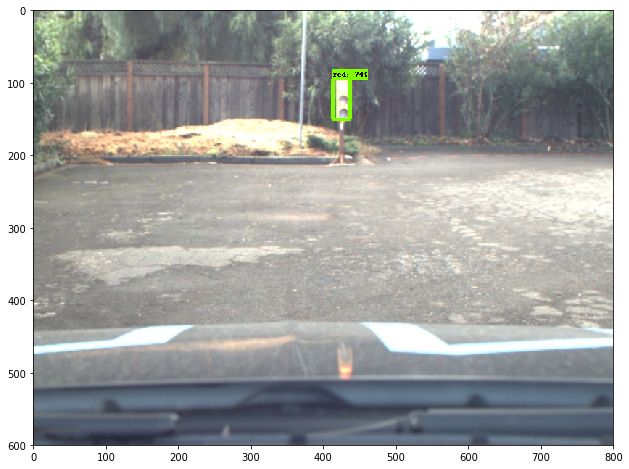

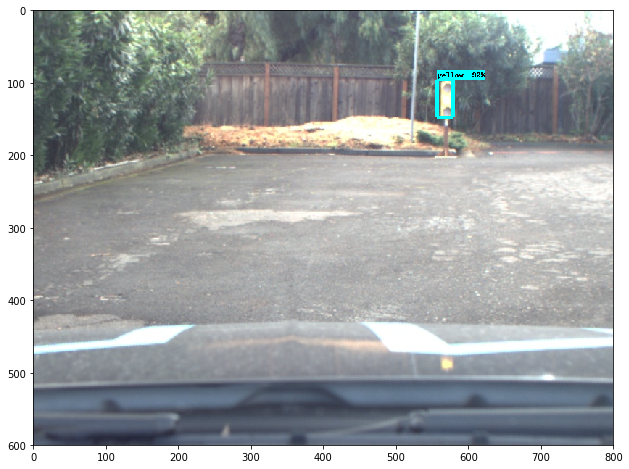

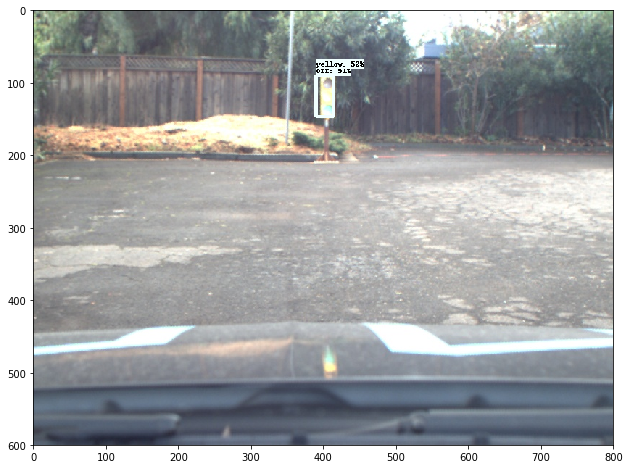

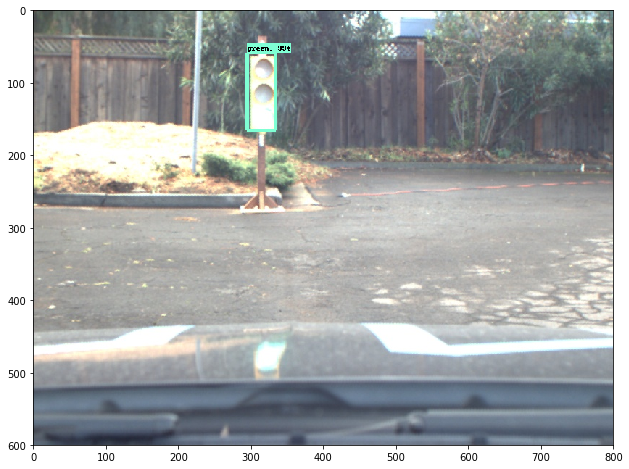

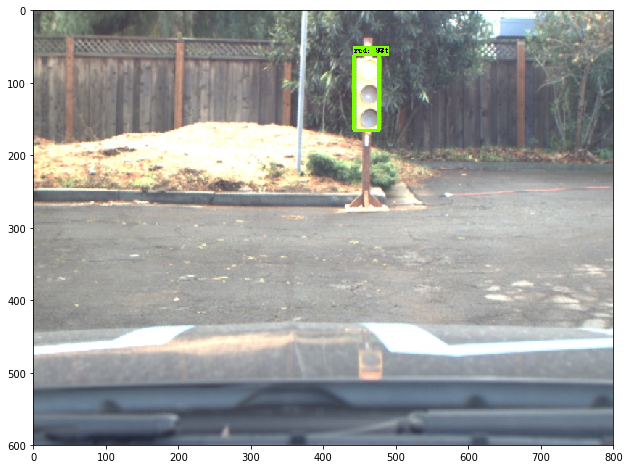

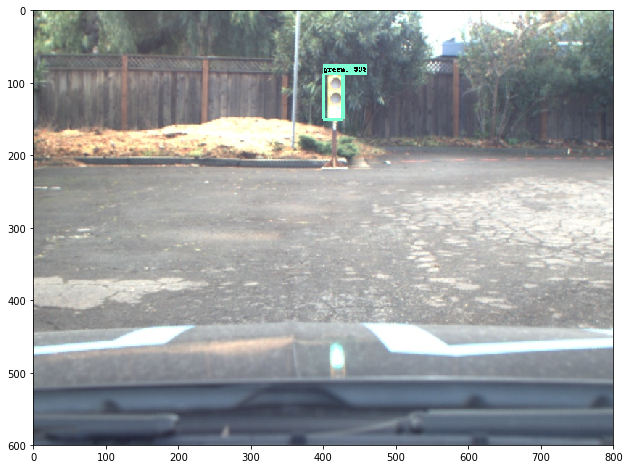

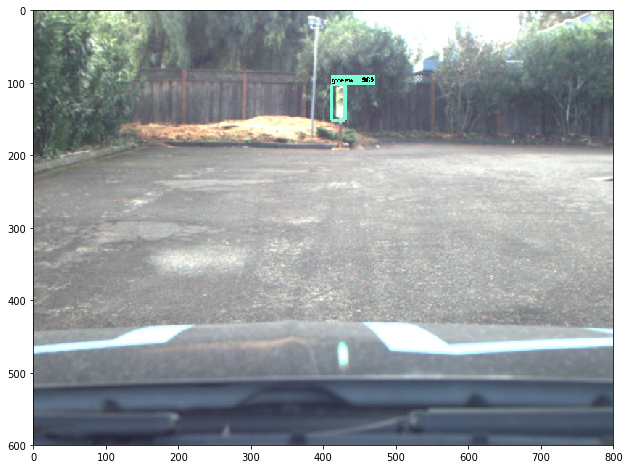

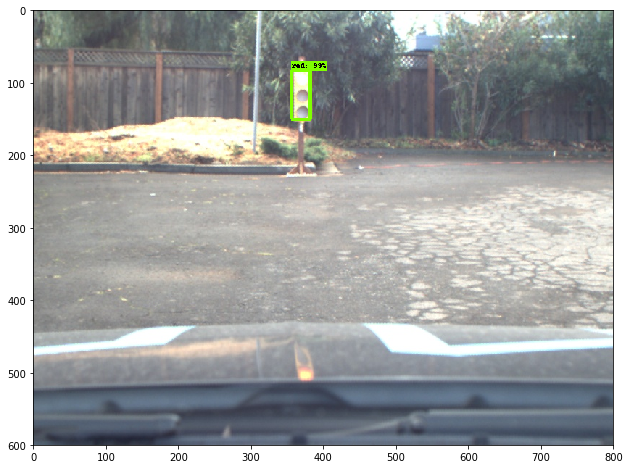

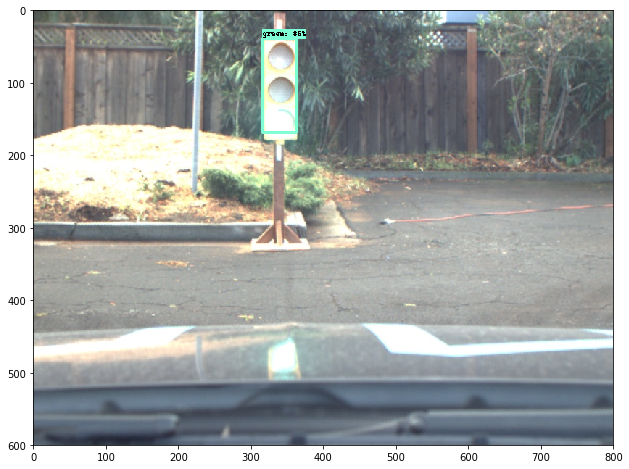

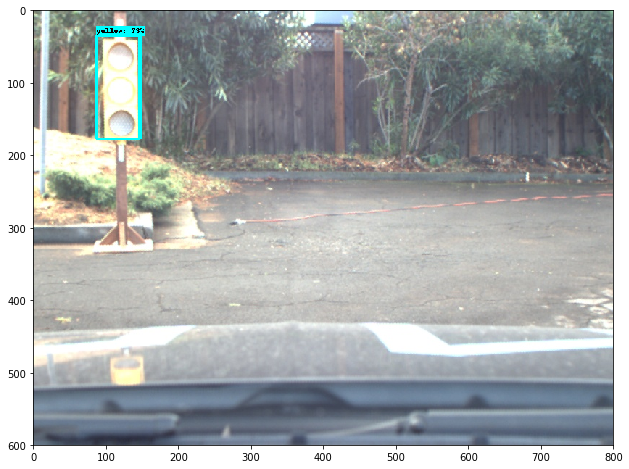

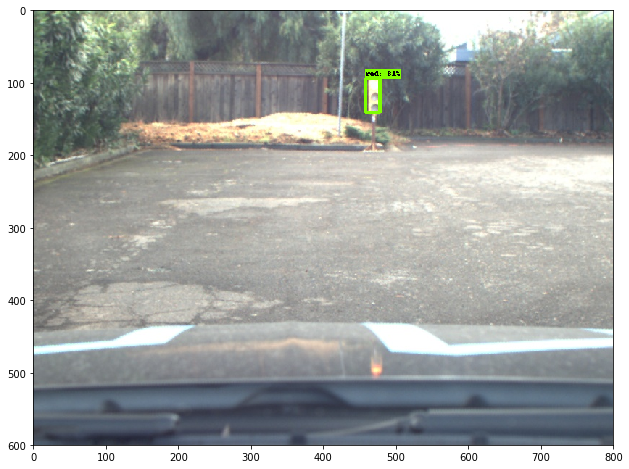

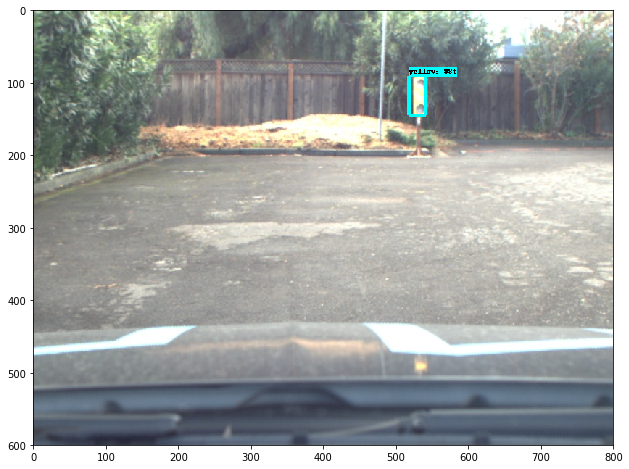

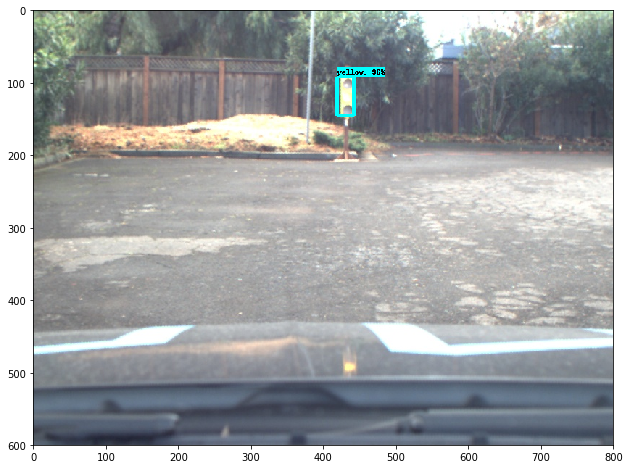

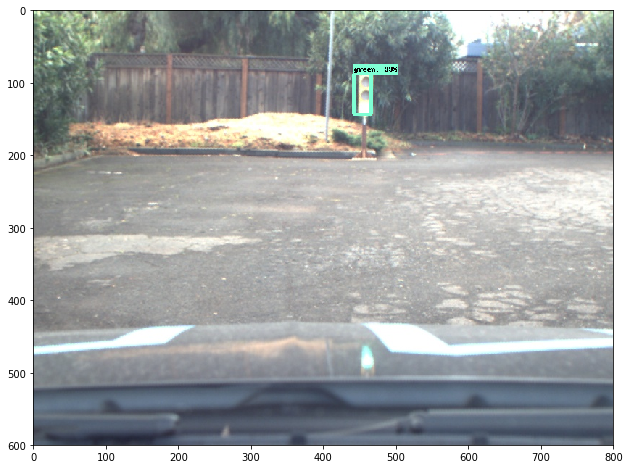

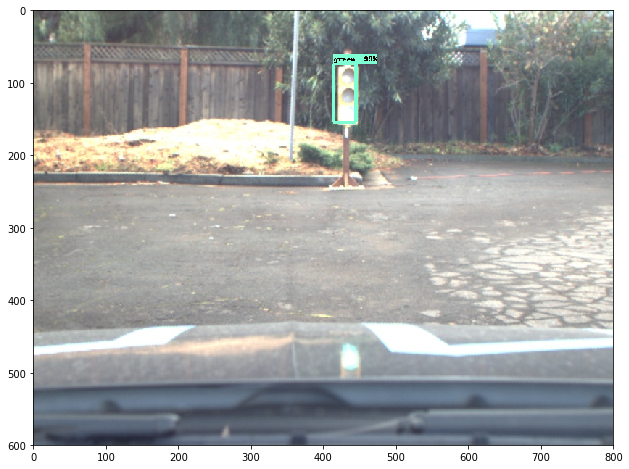

In [10]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open(image_path)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
      # Each box represents a part of the image where a particular object was detected.
      boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
      # Each score represent how level of confidence for each of the objects.
      # Score is shown on the result image, together with the class label.
      scores = detection_graph.get_tensor_by_name('detection_scores:0')
      classes = detection_graph.get_tensor_by_name('detection_classes:0')
      num_detections = detection_graph.get_tensor_by_name('num_detections:0')
      # Actual detection.
      (boxes, scores, classes, num_detections) = sess.run(
          [boxes, scores, classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      # Visualization of the results of a detection.
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=4)
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)